## 1. Data overview and basic analysis 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import normaltest
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import cluster
from sklearn import feature_selection

import warnings
warnings.filterwarnings('ignore')

from IPython.core.display import display, HTML 

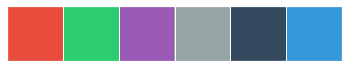

In [2]:
# Setting the color scheme
sns.set_theme(style = "darkgrid")
clrmap = ["#e74c3c","#2ecc71","#9b59b6", "#95a5a6", "#34495e","#3498db"]
sns.set_palette(clrmap)
sns.palplot(sns.color_palette())

In [3]:
taxi_data = pd.read_csv("train.csv")
print('Train data shape: {}'.format(taxi_data.shape))
taxi_data.head()

Train data shape: (1458644, 11)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


We have data on almost 1.5 million trips and 11 characteristics that describe each trip.

Firstly we'll look at the time frame in the data.
We'll transform the *pickup_datetime* attribute to the *datetime* data type with the format year-month-day-hour:minute:second (function *pd.to_datetime()*, parameter *format = '%Y-%m-%d%H:%M:%S'*).

In [4]:
taxi_data['pickup_datetime'] = pd.to_datetime(taxi_data['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
print('Start time of the first trip: ', taxi_data['pickup_datetime'].min().date())
print('Start time of the last trip: ', taxi_data['pickup_datetime'].max().date())

Start time of the first trip:  2016-01-01
Start time of the last trip:  2016-06-30


Let's look at the gaps 

In [5]:
print('Total missing values: ', taxi_data.isnull().sum().sum())

Total missing values:  0


Let's look at the statistical characteristics of some features.

In [6]:
print('a) Number of unique taxi companies: ', taxi_data.vendor_id.nunique())
print('b) Maximum number of passengers: ', taxi_data.passenger_count.max())
print('c) Average trip duration: ', round(taxi_data.trip_duration.mean()))
print('   Median trip duration: ', round(taxi_data.trip_duration.median()))
print('d) Minimum trip duration: ', taxi_data.trip_duration.min())
print('   Maximum trip duration: ', taxi_data.trip_duration.max())

a) Number of unique taxi companies:  2
b) Maximum number of passengers:  9
c) Average trip duration:  959
   Median trip duration:  662
d) Minimum trip duration:  1
   Maximum trip duration:  3526282


Implementing of *add_datetime_features()* function, which takes a table with trips data (Data Frame) as input and returns the same table with 3 columns added to it:

* *pickup_date* - the date when the counter was turned on - the start of the trip (without time);
* *pickup_hour* - the hour of the day when the counter is turned on;
* *pickup_day_of_week* - name of the day of the week when the counter was turned on.

In [7]:
def add_datetime_features(data):
    data['pickup_date'] = data['pickup_datetime'].dt.date
    data['pickup_hour'] = data['pickup_datetime'].dt.hour
    data['pickup_day_of_week'] = data['pickup_datetime'].dt.day_name()
    return data

taxi_data = add_datetime_features(taxi_data)

saturday_count = taxi_data[taxi_data['pickup_day_of_week'] == 'Saturday'].shape[0]
trip_count_mean = taxi_data.shape[0]/taxi_data['pickup_date'].nunique()

print('a) Number of trips on Saturday: ', saturday_count)
print('b) Maximum number of passengers: ', round(trip_count_mean))

a) Number of trips on Saturday:  220868
b) Maximum number of passengers:  8015


Implementing of *add_holiday_features()* function, which takes two tables as input: 
* a table with trips data;
* a table with  holidays data;

and returns an updated table with trip data with the *pickup_holiday* column added to it - a binary indication of whether the trip started on a holiday or not (1 - yes, 0 - no).

In [8]:
holiday_data = pd.read_csv('holiday_data.csv', sep=';')

def add_holiday_features(data, holidays):
    holidays['date'] = pd.to_datetime(holidays['date']).dt.date
    data = data.merge(holidays, left_on='pickup_date', right_on = 'date', how = 'left')
    data['holiday'] = data['holiday'].fillna(0)
    data['pickup_holiday'] = data['holiday'].apply(lambda x: 0 if x == 0 else 1)
    data = data.drop(holidays.columns, axis = 1)
    return data

taxi_data = add_holiday_features(taxi_data, holiday_data)

holiday_trip_duration_median = taxi_data[taxi_data['pickup_holiday']==1]['trip_duration'].median()
print('Median trip duration on holidays: ', round(holiday_trip_duration_median))

Median trip duration on holidays:  585


Implementing of *add_osrm_features()* function, which takes two tables as input:
* a table with trips data;
* a table with data from OSRM;

and returns an updated table with trips data with 3 columns added to it:
* *total_distance*;
* *total_travel_time*;
* *number_of_steps*.

In [9]:
osrm_data = pd.read_csv('osrm_data_train.csv')

def add_osrm_features(data, osrm):
    columns = ['id','total_distance','total_travel_time', 'number_of_steps']
    data = data.merge(osrm[columns], on='id', how = 'left')
    return data

taxi_data = add_osrm_features(taxi_data, osrm_data)

time_difference = taxi_data['trip_duration'].median() - taxi_data['total_travel_time'].median()
print('a) Difference between median trip duration in data and in OSRM: ', round(time_difference))

nulls = taxi_data.isnull().sum()
print('b) Gaps after joining tables:')
display (nulls[nulls>0])

a) Difference between median trip duration in data and in OSRM:  372
b) Gaps after joining tables:


total_distance       1
total_travel_time    1
number_of_steps      1
dtype: int64

In [10]:
def get_haversine_distance(lat1, lng1, lat2, lng2):
    #Converting angles to radians
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    #The radius of the earth in kilometers
    EARTH_RADIUS = 6371 
    #Calculate the shortest distance h by the Haversin formula
    lat_delta = lat2 - lat1
    lng_delta = lng2 - lng1
    d = np.sin(lat_delta * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng_delta * 0.5) ** 2
    h = 2 * EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def get_angle_direction(lat1, lng1, lat2, lng2):
    #Converting angles to radians
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    #Calculate the angle of the direction of movement alpha by the bearing angle formula
    lng_delta_rad = lng2 - lng1
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    alpha = np.degrees(np.arctan2(y, x))
    return alpha

Implementing of *add_geographical_features()* function, which takes a table with trips data as input and returns an updated table with 2 columns added to it:
* *haversine_distance* - the Haversine distance between the point at which the counter was turned on and the point at which the counter was turned off;
* *direction* - the direction of movement from the point where the counter was turned on to the point where the counter was turned off.

In [11]:
def add_geographical_features(data):
    data ['haversine_distance'] = data.apply(lambda x: get_haversine_distance(x['pickup_latitude'], 
                                                                              x['pickup_longitude'], 
                                                                              x['dropoff_latitude'],
                                                                              x['dropoff_longitude']), 
                                                                              axis=1)
    data ['direction'] = data.apply(lambda x: get_angle_direction(x['pickup_latitude'], 
                                                                  x['pickup_longitude'], 
                                                                  x['dropoff_latitude'],
                                                                  x['dropoff_longitude']), 
                                                                  axis=1)  
    return data

taxi_data = add_geographical_features(taxi_data)

print('Median Haversin Distance (km): ', round(taxi_data['haversine_distance'].median(), 2))

Median Haversin Distance (km):  2.09


Implementing of *add_cluster_features()* function, which takes as input a table with trips data and a trained clustering algorithm. The function should return an updated table with the *get_cluster* column added to it - the geographical cluster to which the trip belongs.

In [12]:
#Creating a training sample from the geographical coordinates of all points
coords = np.hstack((taxi_data[['pickup_latitude', 'pickup_longitude']],
                    taxi_data[['dropoff_latitude', 'dropoff_longitude']]))
#Learning the clustering algorithm
kmeans = cluster.KMeans(n_clusters=10, random_state=42)
kmeans.fit(coords)

def add_cluster_features(data, cluster):
    coords = data[['pickup_latitude', 'pickup_longitude','dropoff_latitude', 'dropoff_longitude']]
    predictions = cluster.predict(coords)
    predictions = cluster.labels_
    data ['geo_cluster'] = predictions
    return data

taxi_data = add_cluster_features(taxi_data, kmeans)

smallest_cluster_trip_count = taxi_data[taxi_data['geo_cluster'] == taxi_data['geo_cluster'].value_counts().iloc[-1]].shape[0]
print(f'The smallest geographical cluster contains {smallest_cluster_trip_count} trips')

The smallest geographical cluster contains 2 trips


Implementing of *add_weather_features()* function, which takes two tables as input:

* a table with trips data;
* a table with data on weather conditions for each hour;

and returns an updated table with trips data with 5 columns added to it:
* *temperature* - temperature;
* *visibility* - visibility;
* *wind speed* - average wind speed;
* *precip* - amount of precipitation;
* *events* - weather events.

In [13]:
weather_data = pd.read_csv('weather_data.csv')

def add_weather_features(data, weather):
    weather['time'] = pd.to_datetime(weather['time'], format='%Y-%m-%d %H:%M:%S')
    weather['pickup_date'] = weather['time'].dt.date
    weather['pickup_hour'] = weather['time'].dt.hour
    columns = ['pickup_date','pickup_hour','temperature','visibility','wind speed','precip','events']
    data = data.merge(weather[columns], on=['pickup_date', 'pickup_hour'], how = 'left')
    return data 

taxi_data = add_weather_features(taxi_data, weather_data)

print('a) The number of trips in snowy weather: ', taxi_data[taxi_data['events']=='Snow'].shape[0])

nulls = taxi_data.isnull().sum()
display (nulls[nulls>0])
null_percent = round(taxi_data.isnull().sum().loc['events']/taxi_data.shape[0]*100, 2)
print(f'b) Percentage of gaps in columns with weather conditions: {null_percent} %')

a) The number of trips in snowy weather:  13126


total_distance           1
total_travel_time        1
number_of_steps          1
temperature          12032
visibility           12032
wind speed           12032
precip               12032
events               12032
dtype: int64

b) Percentage of gaps in columns with weather conditions: 0.82 %


Implementing of *fill_null_weather_data()* function, which takes as input a table with trips data. The function should fill in the missing values in the columns.

The gaps in the columns with weather conditions - *temperature*, *visibility*, *wind speed*, *precip* will be filled with the median value of temperature, humidity, wind speed and visibility, depending on the start date of the trip. To do this, we'll group the data by *pickup_date* column and calculate the median in each group, after which we'll fill in the gaps using a combination of *transform()* and *fillna()* methods. 
Fill in the gaps in the events column with the string 'None' - a symbol for the weather events absence  (snow/ rain/ fog). 

The gaps in the columns with information from the OSRM API - *total_distance*, *total_travel_time* and *number_of_steps* will be filled with the median values of these columns.


In [14]:
def fill_null_weather_data(data): 
    weather_columns = ['temperature', 'visibility', 'wind speed', 'precip']
    for col in weather_columns:
        data[col] = data[col].fillna(data.groupby('pickup_date')[col].transform('median'))

    data['events'] = data['events'].fillna('None')
    
    osrm_columns = ['total_distance', 'total_travel_time', 'number_of_steps']
    for col in osrm_columns:
        data[col] = data[col].fillna(data[col].median())
        
    return data

taxi_data = fill_null_weather_data(taxi_data)

print(f'The median in the temperature column after filling in the gaps: {taxi_data.temperature.median()}')

The median in the temperature column after filling in the gaps: 11.1


At the end of the first part, we'll find obvious outliers in the target variable - the trip duration . 

The easiest way - finding too long trips. Let's agree that trips that's duration exceeds 24 hours will be emissions. 

It's a little more difficult to analyze trips whose duration is too short. Because these include really real short-distance trips, trips that were canceled a second after the counter turned on, as well as “teleportation” - moving long distances in a seconds. 
Let's agree that we'll consider only the last group as outliers. 

We can use the information about the shortest distance that a taxi passes. Calculating the average speed of the taxi on the shortest path as follows:
$$avg\_speed= \frac{total\_distance}{1000*trip\_duration}*3600$$
Let's make a scattering diagram of the average taxi speed 

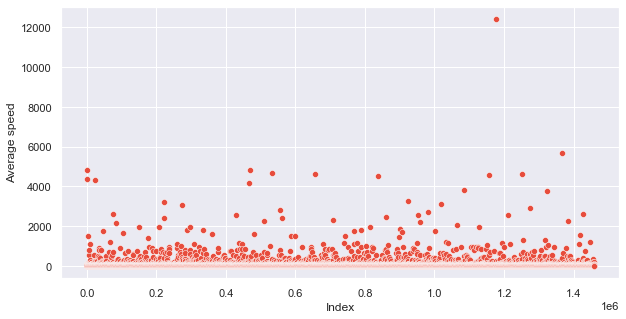

In [15]:
avg_speed = taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(x=avg_speed.index, y=avg_speed, ax=ax)
ax.set_xlabel('Index')
ax.set_ylabel('Average speed');

Here we see that there are “teleportation trips” where the average speed is more than 1000 km/h. Let's agree that the maximum average speed that taxi drivers can get will be 300 km/h.

We'll find trips that's duration exceeds 24 hours. And removed them from the dataset.

We will find trips that's  average speed along the shortest path exceeds 300 km/h and delete them from the dataset.

In [16]:
print('а) Number of trips lasting more than 24 hours: ', taxi_data[taxi_data['trip_duration'] > 60*60*24].shape[0])

taxi_data['avg_speed'] = taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6
print('b) The number of trips with a speed of more than 300 km/h: ', taxi_data[taxi_data['avg_speed'] > 300].shape[0])

taxi_data = taxi_data[taxi_data['trip_duration'] <= 60*60*24]
taxi_data = taxi_data[taxi_data['avg_speed'] <= 300]

а) Number of trips lasting more than 24 hours:  4
b) The number of trips with a speed of more than 300 km/h:  407


## 2. Exploration Data Analysis (EDA)

We start with the target variable. The main quality metric of solving the task will be RMSLE - Root Mean Squared Log Error, which is calculated based on the target variable on a logarithmic scale. In this case, it is relevant to immediately log the trip duration feature and consider the logarithm as the target feature in the analysis:
$$trip\_duration\_log = log(trip\_duration+1)$$


In [17]:
taxi_data['trip_duration_log'] = np.log(taxi_data['trip_duration']+1)

Let's make a histogram and a box diagram of the trip duration on a logarithmic scale (trip_duration_log).
Based on the visualization, we'll make an assumption whether the resulting distribution is normal.
Let's test our hypothesis using the D'Agostino test at the significance level $\alpha=0.05$. 

p=0.000
The data is NOT distributed normally


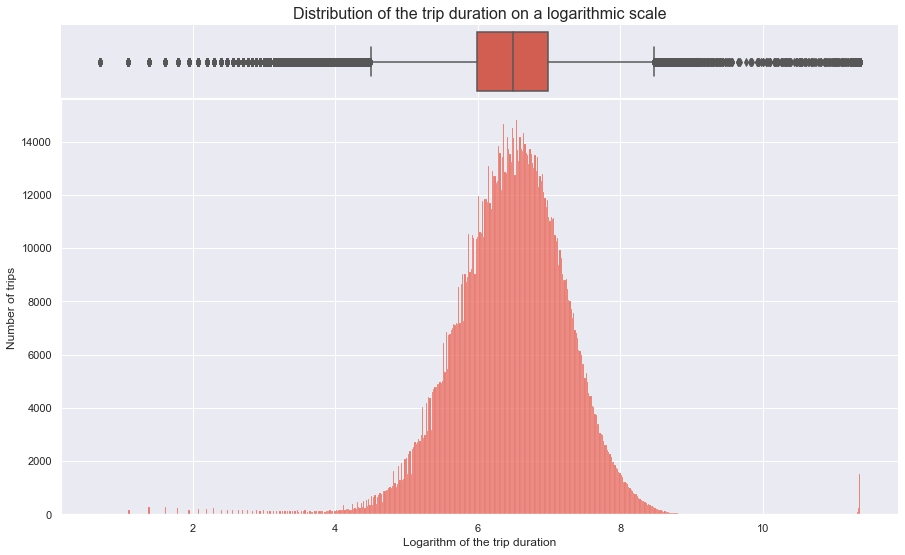

In [18]:
H0 = 'The data is distributed normally'
Ha = 'The data is NOT distributed normally'

alpha = 0.05

_, p = normaltest(taxi_data['trip_duration_log'])
print('p=%.3f' % p)

if p > alpha/2:
    print(H0)
else:
    print(Ha)

fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, figsize = (15, 9),
                                    gridspec_kw={"height_ratios": (.15, .85)})

plt.subplots_adjust(hspace = 0.01)

sns.boxplot(taxi_data['trip_duration_log'], ax=ax_box)
sns.histplot(taxi_data['trip_duration_log'], ax=ax_hist)
ax_box.set(yticks=[])
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)
ax_box.set_title('Distribution of the trip duration on a logarithmic scale', fontsize = 16);
ax_hist.set_xlabel('Logarithm of the trip duration');
ax_hist.set_ylabel('Number of trips');

Let's make a visualization that will allow us to compare the distribution of the trip duration on a logarithmic scale (trip_duration_log) depending on the taxi company (vendor_id). 

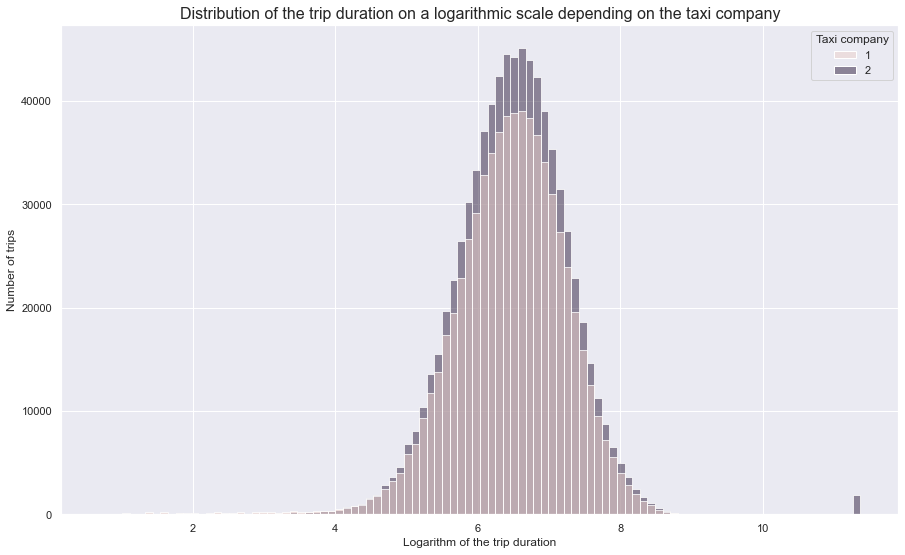

In [19]:
fig = plt.figure(figsize = (15, 9));
histplot = sns.histplot(taxi_data, x='trip_duration_log', hue='vendor_id', bins = 100)
histplot.set_title('Distribution of the trip duration on a logarithmic scale depending on the taxi company', fontsize = 16);
histplot.set_xlabel('Logarithm of the trip duration');
histplot.set_ylabel('Number of trips');
legend = histplot.get_legend()
handles = legend.legendHandles
legend.remove()
histplot.legend(handles, ['1', '2'], title='Taxi company')
plt.show() 

Let's make a visualization that will allow us to compare the distribution of the trip duration on a logarithmic scale (trip_duration_log) depending on the feature of sending a message to the supplier (store_and_fwd_flag). 

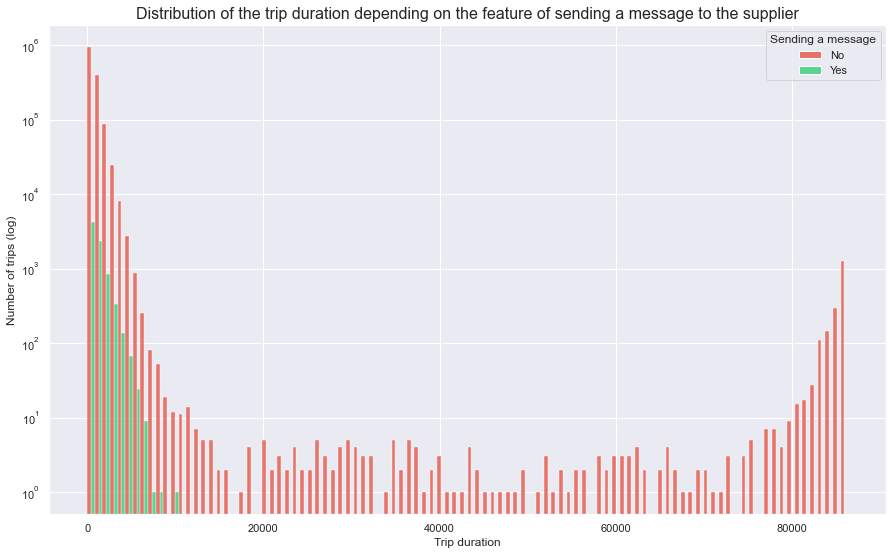

In [20]:
fig = plt.figure(figsize = (15, 9));
histplot = sns.histplot(taxi_data, x='trip_duration', hue='store_and_fwd_flag', multiple='dodge', log_scale=(False, True), bins = 100)
histplot.set_title('Distribution of the trip duration depending on the feature of sending a message to the supplier', fontsize = 16);
histplot.set_xlabel('Trip duration');
histplot.set_ylabel('Number of trips (log)');
legend = histplot.get_legend()
handles = legend.legendHandles
legend.remove()
histplot.legend(handles, ['No', 'Yes'], title='Sending a message')
plt.show() 

Let's make two visualizations:
* Distribution of the number of trips depending on the hour of the day;
* The dependence of the median trip duration on the hour of the day.

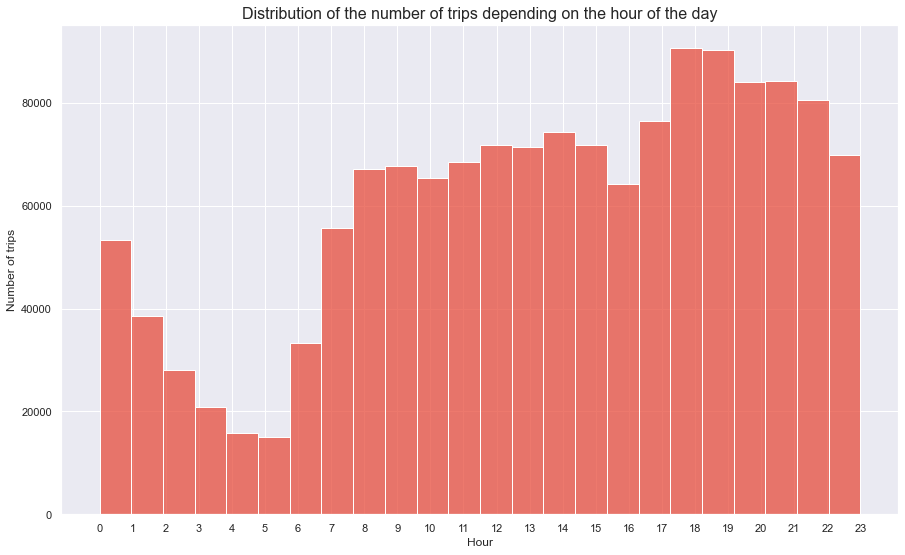

а) Most rarely a taxi is ordered from 0:00 to 6:00


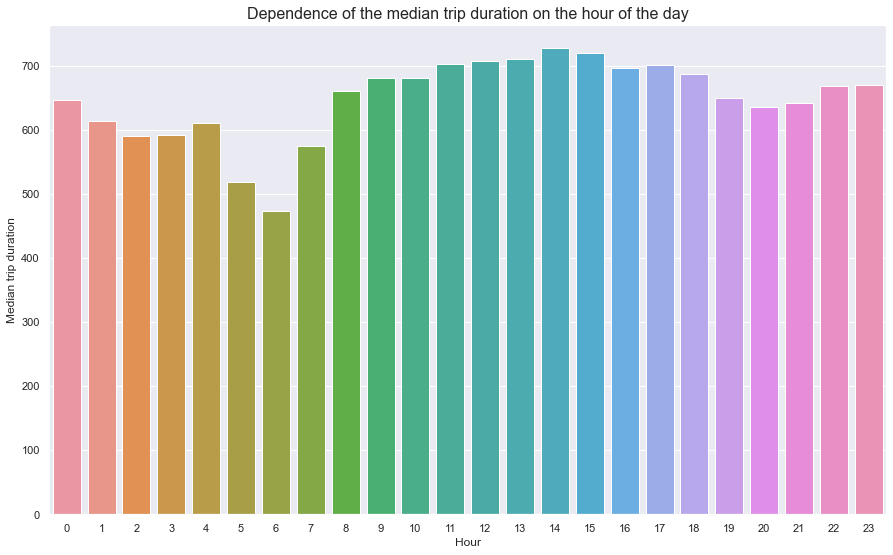

b) The peak of the median trip duration is observed from 13:00 to 15:00


In [21]:
fig = plt.figure(figsize = (15, 9))

histplot = sns.histplot(
    data = taxi_data,
    x = 'pickup_hour',
    bins = 24,
    );
histplot.set_title('Distribution of the number of trips depending on the hour of the day', fontsize = 16);
histplot.set_xlabel('Hour');
histplot.set_ylabel('Number of trips');
histplot.set_xticks(range(0, 24, 1));

plt.show()
print ('а) Most rarely a taxi is ordered from 0:00 to 6:00')
bar_data = taxi_data.groupby(by = 'pickup_hour', as_index = False)['trip_duration'].median()
fig = plt.figure(figsize = (15, 9));

barplot = sns.barplot(data = bar_data, x = 'pickup_hour', y = 'trip_duration');
barplot.set_ylabel('Median trip duration');
barplot.set_xlabel('Hour');
barplot.set_title('Dependence of the median trip duration on the hour of the day', fontsize = 16);

plt.show()
print ('b) The peak of the median trip duration is observed from 13:00 to 15:00')

Let's make two visualizations:
* Distribution of the number of trips depending on the day of the week;
* The dependence of the median trip duration on the day of the week.

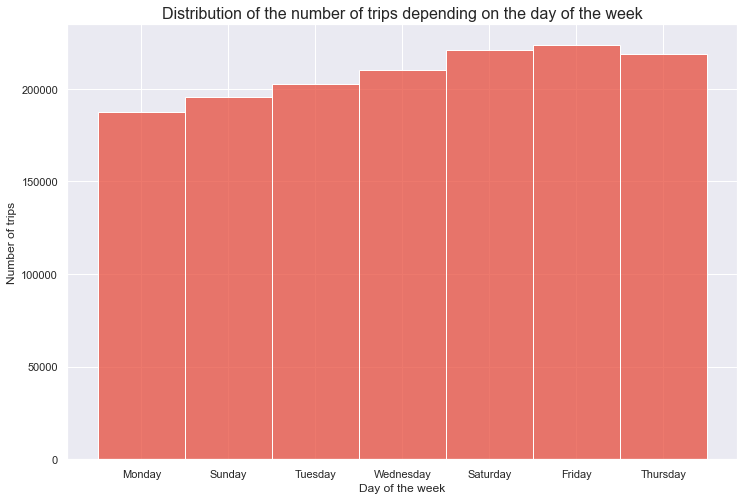

а) Most trips are made on Friday


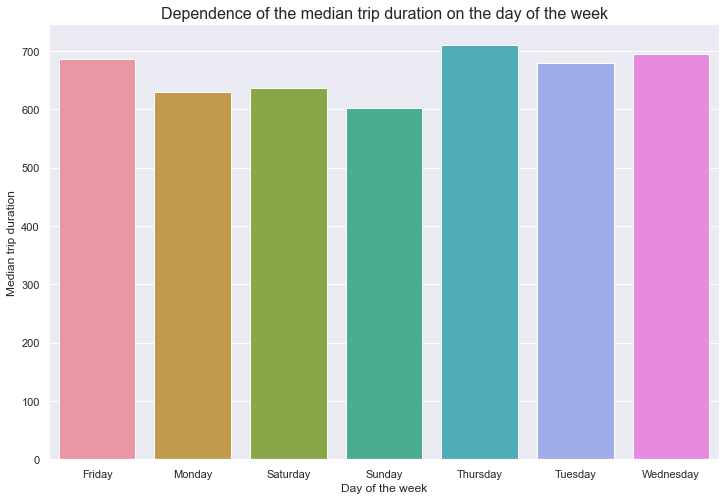

b) Median trip duration is the shortest on Sunday


In [22]:
fig = plt.figure(figsize = (12, 8))

histplot = sns.histplot(
    data = taxi_data,
    x = 'pickup_day_of_week',
    bins = 7,
    );
histplot.set_title('Distribution of the number of trips depending on the day of the week', fontsize = 16);
histplot.set_xlabel('Day of the week');
histplot.set_ylabel('Number of trips');
#histplot.set_xticks(range(0, 24, 1));

plt.show()
print ('а) Most trips are made on Friday')
bar_data = taxi_data.groupby(by = 'pickup_day_of_week', as_index = False)['trip_duration'].median()
fig = plt.figure(figsize = (12, 8));

barplot = sns.barplot(data = bar_data, x = 'pickup_day_of_week', y = 'trip_duration');
barplot.set_ylabel('Median trip duration');
barplot.set_xlabel('Day of the week');
barplot.set_title('Dependence of the median trip duration on the day of the week', fontsize = 16);

plt.show()
print ('b) Median trip duration is the shortest on Sunday')

Let's look at both time characteristics at the same time.

Let's make a summary table with the hours (pickup_hour) on the rows, the days of the week (pickup_day_of_week) on the columns, and the median trip duration (trip_duration) in the cells.

We'll visualize the resulting summary table using a heat map.

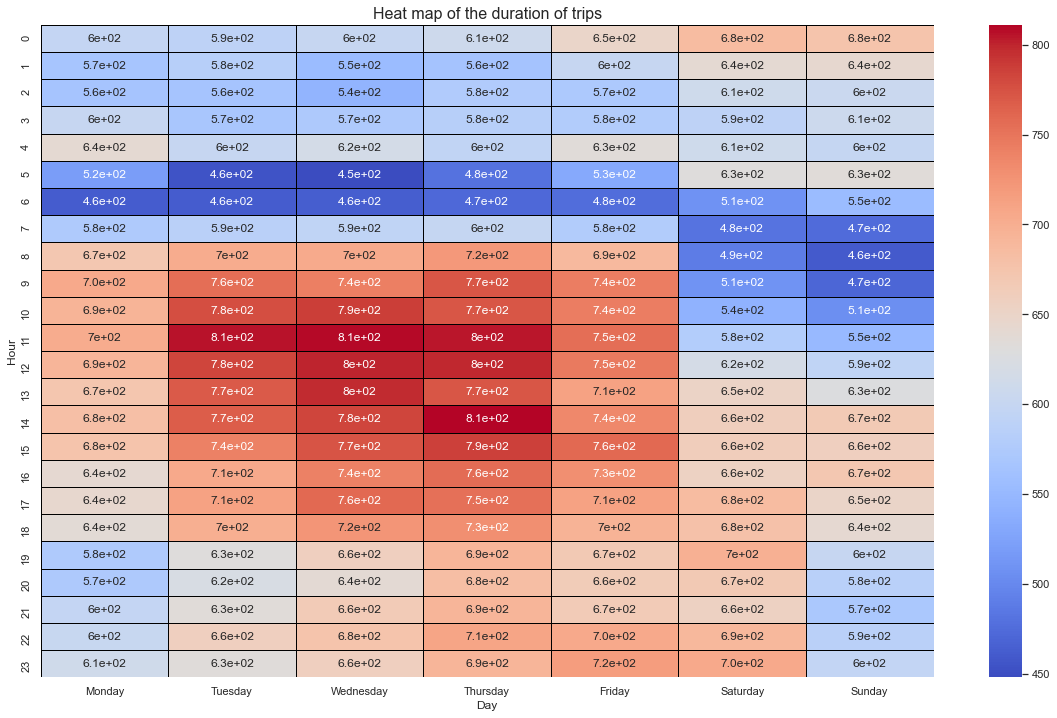

In [23]:
pivot = taxi_data.pivot_table(
    values = 'trip_duration',
    index = 'pickup_hour',
    columns = 'pickup_day_of_week',
    aggfunc = 'median',
    )
pivot = pivot[['Monday', 'Tuesday', 'Wednesday','Thursday','Friday','Saturday', 'Sunday']]

fig = plt.figure(figsize = (20, 12));

heatmap = sns.heatmap(pivot, annot = True, cmap = 'coolwarm', linewidths = 1, linecolor = 'black');
heatmap.set_title('Heat map of the duration of trips', fontsize = 16);
heatmap.set_xlabel('Day');
heatmap.set_ylabel('Hour');

plt.show()

Let's make two scatter diagrams:
* the first one should illustrate the geographical location of the start points of trips (pickup_longitude, pickup_latitude)
* * the second should be the geographical location of the points of completion of trips (dropoff_longitude, drop of_litude).

To do this, we will put longitude on the diagrams along the abscissa axis, and latitude on the ordinate axis.
We will include in the visualization only those points that are located within New York - we will add the following restrictions on the boundaries of the abscissa and ordinate axes:
 
city_long_border = (-74.03, -73.75)

city_lat_border = (40.63, 40.85)

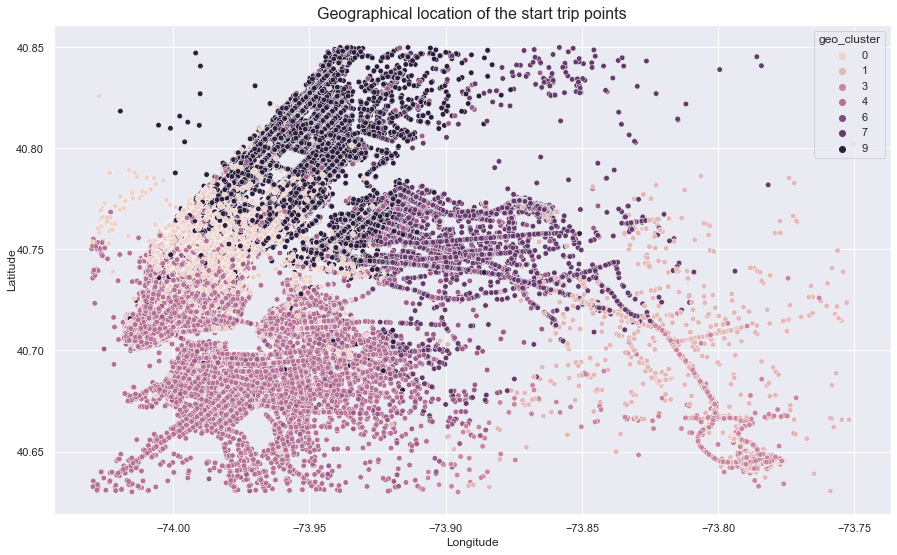

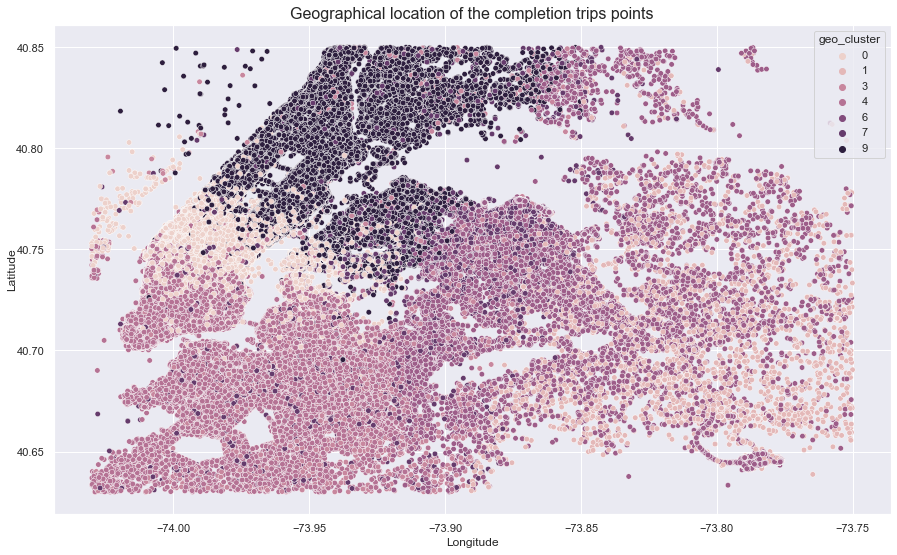

In [24]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

mask_1 = (taxi_data['pickup_latitude'] >= city_lat_border[0]) & (taxi_data['pickup_latitude'] <= city_lat_border[1])
mask_2 = (taxi_data['pickup_longitude'] >= city_long_border[0]) & (taxi_data['pickup_longitude'] <= city_long_border[1])
pickup_scatter_data = taxi_data [mask_1 & mask_2]

fig = plt.figure(figsize = (15, 9));
scatterplot = sns.scatterplot(data = pickup_scatter_data, 
                              x = 'pickup_longitude', 
                              y = 'pickup_latitude', 
                              s = 30,
                              hue = 'geo_cluster'
                             );
scatterplot.set_ylabel('Latitude', va = 'center');
scatterplot.set_title('Geographical location of the start trip points', fontsize = 16);
scatterplot.set_xlabel('Longitude');
plt.show() 

mask_3 = (taxi_data['dropoff_latitude'] > city_lat_border[0]) & (taxi_data['dropoff_latitude'] < city_lat_border[1])
mask_4 = (taxi_data['dropoff_longitude'] > city_long_border[0]) & (taxi_data['dropoff_longitude'] < city_long_border[1])
dropoff_scatter_data = taxi_data [mask_3 & mask_4]

fig = plt.figure(figsize = (15, 9));
scatterplot = sns.scatterplot(data = dropoff_scatter_data, 
                              x = 'dropoff_longitude', 
                              y = 'dropoff_latitude', 
                              s = 30,
                              hue = 'geo_cluster'
                             );
scatterplot.set_ylabel('Latitude', va = 'center');
scatterplot.set_title('Geographical location of the completion trips points', fontsize = 16);
scatterplot.set_xlabel('Longitude');
plt.show()

## 3. Feature engineering

In [25]:
print('Shape of data: {}'.format(taxi_data.shape))
print('Columns: {}'.format(taxi_data.columns))

Shape of data: (1458233, 28)
Columns: Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_date', 'pickup_hour', 'pickup_day_of_week',
       'pickup_holiday', 'total_distance', 'total_travel_time',
       'number_of_steps', 'haversine_distance', 'direction', 'geo_cluster',
       'temperature', 'visibility', 'wind speed', 'precip', 'events',
       'avg_speed', 'trip_duration_log'],
      dtype='object')


For the convenience of work, we'll make a copy of the original table with trips:

In [26]:
train_data = taxi_data.copy()
train_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,haversine_distance,direction,geo_cluster,temperature,visibility,wind speed,precip,events,avg_speed,trip_duration_log
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,1.498521,99.970196,9,4.4,8.0,27.8,0.3,None,15.896176,6.122493
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,1.805507,-117.153768,4,28.9,16.1,7.4,0.0,None,13.646335,6.498282
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,6.385098,-159.680165,4,-6.7,16.1,24.1,0.0,None,18.747119,7.661527
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,1.485498,-172.737700,4,7.2,16.1,25.9,0.0,None,14.932028,6.063785
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,1.188588,179.473585,9,9.4,16.1,9.3,0.0,None,13.364690,6.077642


In [27]:
train_data = train_data.drop(['id','dropoff_datetime','avg_speed'], axis=1)

Previously, we extracted all the information necessary for us from the start date of the trip, now we can get rid of these signs, since we will no longer need them:

In [28]:
drop_columns = ['pickup_datetime', 'pickup_date']
train_data = train_data.drop(drop_columns, axis=1)
print('Shape of the data:  {}'.format(train_data.shape))

Shape of the data:  (1458233, 23)


Encode the vendor_id feature in the train_data table so that it is equal to 0 if the taxi company ID is 1, and 1 if otherwise.

Also we encode the store_and_fwd_flag feature in the train_data table so that it is equal to 0 if the flag is set to "N", and 0 if otherwise.

In [29]:
train_data['vendor_id'] = train_data['vendor_id'].apply(lambda x: 0 if x == 1 else 1)
train_data['store_and_fwd_flag'] = train_data['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)
print('a) The average of the encoded column vendor_id: ', round (train_data['vendor_id'].mean(), 2))
print('b) The average of the encoded column store_and_fwd_flagу: ', round (train_data['store_and_fwd_flag'].mean(), 3))

a) The average of the encoded column vendor_id:  0.53
b) The average of the encoded column store_and_fwd_flagу:  0.006


Let's create a data_onehot table from the once-encoded pickup_day_of_week, pickup_dropoff_cluster and events featuress in the train_data table using OneHotEndoder() from the sklearn library.

In [30]:
from sklearn.preprocessing import OneHotEncoder
columns_to_change = ['pickup_day_of_week', 'geo_cluster', 'events']
encoder = OneHotEncoder(drop = 'first') 
data_onehot = encoder.fit_transform(train_data[columns_to_change]).toarray()
columns = encoder.get_feature_names(columns_to_change)
data_onehot = pd.DataFrame(data_onehot, columns=columns)
print (f'It turned out to generate {data_onehot.shape[1]} features using encoding')

It turned out to generate 18 features using encoding


In [31]:
train_data = pd.concat(
    [train_data.reset_index(drop=True).drop(columns_to_change, axis=1), data_onehot], 
    axis=1
)
print('Shape of the data: {}'.format(train_data.shape))

Shape of the data: (1458233, 38)


Now that the categorical features are preprocessed, we'll form a matrix of observations X, the vector of the target feature y and its logarithm y_log. The observation matrix will include all columns from the trip table with the exception of the trip_duration target attribute and its logarithmic version trip_duration_log:

In [32]:
X = train_data.drop(['trip_duration', 'trip_duration_log'], axis=1)
y = train_data['trip_duration']
y_log = train_data['trip_duration_log']

The selected validation type is hold-out. Let's divide the sample into training and validation in the ratio 67/33:

In [33]:
X_train, X_valid, y_train_log, y_valid_log = model_selection.train_test_split(
    X, y_log, 
    test_size=0.33, 
    random_state=42
)

Using SelectKBest, we'll select 25 features that are best suited for predicting target feature on a logarithmic scale. The selection is implemented using a training sample using the parameter score_func = f_regression.

In [34]:
from sklearn.feature_selection import SelectKBest, f_regression
selector = SelectKBest(f_regression, k=25)
selector.fit(X_train, y_train_log)
cols = selector.get_support(indices=True)
best_list = list(X_train.iloc[:,cols].columns)
best_list

['vendor_id',
 'passenger_count',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'store_and_fwd_flag',
 'pickup_hour',
 'pickup_holiday',
 'total_distance',
 'total_travel_time',
 'number_of_steps',
 'haversine_distance',
 'temperature',
 'pickup_day_of_week_Monday',
 'pickup_day_of_week_Saturday',
 'pickup_day_of_week_Sunday',
 'pickup_day_of_week_Thursday',
 'pickup_day_of_week_Tuesday',
 'pickup_day_of_week_Wednesday',
 'geo_cluster_1',
 'geo_cluster_3',
 'geo_cluster_5',
 'geo_cluster_7',
 'geo_cluster_9']

Since we'll use various models, including those with numerical optimization methods, we will take care of scaling factors in advance.

Lets normalize predictors in training and validation samples using MinMaxScaler from the sklearn library.

In [35]:
X_train = X_train[best_list]
X_valid = X_valid[best_list]

In [36]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=best_list)
X_valid_scaled = pd.DataFrame(scaler.transform(X_valid), columns=best_list)

## 4. Solving the regression task: linear regression and decision trees

Let's define the metric by which we will measure the quality of our models. We will follow the canons of the original Kaggle competition and use RMSLE (Root Mean Squared Log Error) as a metric, which is calculated as:
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(log(y_i+1)-log(\hat{y_i}+1))^2},$$
where:
* $y_i$ - true duration of the i-th taxi trip (trip_duration)
* $\hat{y_i}$- the duration of the i-th taxi trip predicted by the model

We've already carried out the logarithm of the target feature in advance, so it will be enough to calculate the RMSLE metric for a model trained to predict the trip duration on a logarithmic scale:

$$z_i=log(y_i+1),$$
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(z_i-\hat{z_i})^2}=\sqrt{MSE(z_i,\hat{z_i})}$$ 



Let's make a linear regression model on a training sample.

In [37]:
#Creating an object of the Linear Regression class
lr= linear_model.LinearRegression()
#Training the model — we are looking for parameters according to the LSM
lr.fit(X_train_scaled,  y_train_log)
y_train_predict = lr.predict(X_train_scaled)
y_valid_predict = lr.predict(X_valid_scaled)
print('Train RMSLE score: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log,y_train_predict))))
print('Test RMSLE score: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_valid_log,y_valid_predict))))

Train RMSLE score: 0.54
Test RMSLE score: 0.54


Let's generate polynomial features of the 2nd degree using PolynomialFeatures from the sklearn library.
Let's make a 2nd degree polynomial regression model on a training sample.

In [38]:
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
poly.fit(X_train_scaled)
#Generating polynomial features for a training sample
X_train_poly = poly.transform(X_train_scaled)
#Generating polynomial features for a test sample
X_valid_poly = poly.transform(X_valid_scaled)

lr_model_poly = linear_model.LinearRegression()
#Training the model by the LSM
lr_model_poly.fit(X_train_poly, y_train_log)
#Making a prediction for a training sample
y_train_predict_poly = lr_model_poly.predict(X_train_poly)
#Making a prediction for a test sample
y_valid_predict_poly = lr_model_poly.predict(X_valid_poly)
                  
print('Train RMSLE score: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_predict_poly))))
print('Test RMSLE score: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_predict_poly))))

Train RMSLE score: 0.47
Test RMSLE score: 0.70


Let's make a 2nd degree polynomial regression model with L2-regularization (Tikhonov regularization) on a training sample.

In [39]:
ridge_lr_poly = linear_model.Ridge(alpha=1)
#Training the model
ridge_lr_poly.fit(X_train_poly, y_train_log)
#Making a prediction for a training sample
y_train_predict_poly = ridge_lr_poly.predict(X_train_poly)
#Making a prediction for a test sample
y_valid_predict_poly = ridge_lr_poly.predict(X_valid_poly)

print('Train RMSLE score: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_predict_poly))))
print('Test RMSLE score: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_predict_poly))))

Train RMSLE score: 0.48
Test RMSLE score: 0.48


Decision Tree model (Decision Tree Regressor) on a training sample.

In [40]:
from sklearn.tree import DecisionTreeRegressor
regr = DecisionTreeRegressor()
regr.fit(X_train_scaled,  y_train_log)

y_train_predict = regr.predict(X_train_scaled)
y_valid_predict = regr.predict(X_valid_scaled)
print('Train RMSLE score: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log,y_train_predict))))
print('Test RMSLE score: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_valid_log,y_valid_predict))))

Train RMSLE score: 0.00
Test RMSLE score: 0.57


Let's go through all possible options for the depth of the decision tree in the range from 7 to 20:

max_depths = range(7, 20)

We'll make linear graphs of changes in the RMSLE metric on training and validation samples depending on the value of the depth parameter of the decision tree.

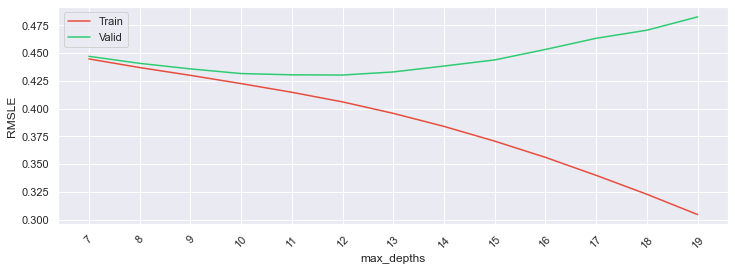

In [41]:
max_depths = range(7, 20)
#Creating empty lists to which we will add the results
train_scores = []
valid_scores = []
for depth in max_depths:
    #Creating an object of the linear regression class with L1 regularization
    regr = DecisionTreeRegressor(max_depth = depth)
    #Training the model
    regr.fit(X_train_scaled,  y_train_log)
    #Making a prediction for a training sample
    y_train_predict = regr.predict(X_train_scaled)
    #Making a prediction for a test sample
    y_valid_predict = regr.predict(X_valid_scaled)
    #Calculating the determination coefficients for two samples and add them to the lists
    train_scores.append(np.sqrt(metrics.mean_squared_error(y_train_log,y_train_predict)))
    valid_scores.append(np.sqrt(metrics.mean_squared_error(y_valid_log,y_valid_predict)))
    
fig, ax = plt.subplots(figsize=(12, 4)) 
ax.plot(max_depths, train_scores, label='Train') 
ax.plot(max_depths, valid_scores, label='Valid') 
ax.set_xlabel('max_depths') 
ax.set_ylabel('RMSLE') 
ax.set_xticks(max_depths) 
ax.xaxis.set_tick_params(rotation=45) 
ax.legend(); 

In [42]:
regr = DecisionTreeRegressor(max_depth = 12)
regr.fit(X_train_scaled,  y_train_log)

y_train_predict = regr.predict(X_train_scaled)
y_valid_predict = regr.predict(X_valid_scaled)
print('Train RMSLE score: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log,y_train_predict))))
print('Test RMSLE score: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_valid_log,y_valid_predict))))

Train RMSLE score: 0.41
Test RMSLE score: 0.43


## 5. Solving the regression task: ensemble methods and forecasting

Let's make the random forest model on a training sample. As hyperparameters , we specify the following:
* n_estimators=200,
* max_depth=12,
* criterion='squared_error',
* min_samples_split=20,
* random_state=42


In [43]:
from sklearn.ensemble import RandomForestRegressor

RFregr = RandomForestRegressor(max_depth=12, n_estimators=200, criterion='squared_error', min_samples_split=20, random_state=42)
RFregr.fit(X_train_scaled,  y_train_log)

y_train_predict = RFregr.predict(X_train_scaled)
y_valid_predict = RFregr.predict(X_valid_scaled)
print('Train RMSLE score: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log,y_train_predict))))
print('Test RMSLE score: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_valid_log,y_valid_predict))))

Train RMSLE score: 0.40
Test RMSLE score: 0.41


Let's make the gradient boosting model over decision trees. As hyperparameters , we specify the following:
* learning_rate=0.5,
* n_estimators=100,
* max_depth=6, 
* min_samples_split=30,
* random_state=42


In [44]:
from sklearn.ensemble import GradientBoostingRegressor
gb = GradientBoostingRegressor(
    max_depth=6, 
    learning_rate=0.5,
    n_estimators=100, 
    min_samples_split=30,
    random_state=42 
)
gb.fit(X_train_scaled,  y_train_log)
 
y_train_predict = gb.predict(X_train_scaled)
y_valid_predict = gb.predict(X_valid_scaled)
print('Train RMSLE  score: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log,y_train_predict))))
print('Test RMSLE: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_valid_log,y_valid_predict))))

Train RMSLE  score: 0.37
Test RMSLE: 0.39


Let's create a bar chart of the coefficients of significance of each factor.

<AxesSubplot:>

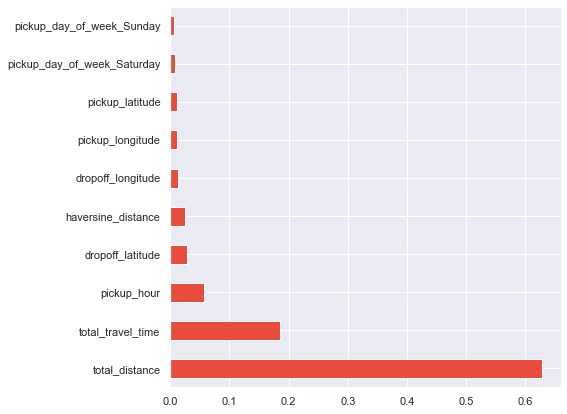

In [45]:
plt.rcParams['figure.figsize'] = (7,7)
feat_importances = pd.Series(gb.feature_importances_, index=X_train_scaled.columns)
feat_importances.nlargest(10).plot(kind='barh')

For the best of the created models, we'll calculate the median absolute error (MeAE - in sklearn the media_absolute_error function) of predicting the trip duration on a validation sample:
$$ MeAE = median(|y_i-\hat{y_i}|)$$

The value of the MeAE metric will be converted to minutes and rounded to tenths.

In [46]:
import math
MeAE = (metrics.median_absolute_error((math.e**(y_valid_log)-1) , (math.e**(y_valid_predict)-1))/60)
print('MeAE score: {:.2f}'.format(round(MeAE, 1)))

MeAE score: 1.80


The final step is to make a submit prediction for the deferred test dataset.

Let's read the test data and select a column with trip ids from the test dataset in advance. We'll need it again:

In [47]:
test_data = pd.read_csv("test_data.csv")
osrm_data_test = pd.read_csv("osrm_data_test.csv")
test_id = test_data['id']

In [48]:
test_data['pickup_datetime']=pd.to_datetime(test_data['pickup_datetime'],format='%Y-%m-%d %H:%M:%S')
test_data = add_datetime_features(test_data)
test_data = add_holiday_features(test_data, holiday_data)
test_data = add_osrm_features(test_data, osrm_data_test)
test_data = add_geographical_features(test_data)

coords = test_data[['pickup_latitude', 'pickup_longitude','dropoff_latitude', 'dropoff_longitude']]
predictions = kmeans.predict(coords)
test_data['geo_cluster'] = predictions


test_data = add_weather_features(test_data, weather_data)
test_data = fill_null_weather_data(test_data)

test_data['vendor_id'] = test_data['vendor_id'].apply(lambda x: 0 if x == 1 else 1)
test_data['store_and_fwd_flag'] = test_data['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)
test_data_onehot = encoder.fit_transform(test_data[columns_to_change]).toarray()
column_names = encoder.get_feature_names_out(columns_to_change)
test_data_onehot = pd.DataFrame(test_data_onehot, columns=column_names)

test_data = pd.concat(
    [test_data.reset_index(drop=True).drop(columns_to_change, axis=1), test_data_onehot], 
    axis=1
)
X_test = test_data[best_list]
X_test_scaled = scaler.transform(X_test)
print('Shape of data: {}'.format(X_test.shape))

Shape of data: (625134, 25)


After completing all these steps, we can make a prediction of the trip duration for the test sample. It is also necessary to translate the predictions from the logarithmic scale to the true one using the formula:
$$y_i=exp(z_i)-1$$

In [49]:
y_test_predict = np.exp(gb.predict(X_test_scaled)) - 1

In [50]:
submission = pd.DataFrame({'id': test_id, 'trip_duration': y_test_predict})
submission.to_csv('submission_gb.csv', index=False)

Finally, using the ensemble method, we'll try to improve our prediction using the extreme gradient boosting (XGBoost) model from the xgboost library.

**XGBoost** is a modern machine learning model that is a continuation of Friedman's gradient boosting idea. It has several advantages over the classic gradient boosting model from the sklearn library: increased productivity by parallelizing the learning process, improved quality of the solution by improving the boosting algorithm, less tendency to retraining and a wide range of functionality for controlling the parameters of the model.

In [51]:
#pip install xgboost

In [52]:
import xgboost as xgb

Before training the model, it is necessary to convert the datasets to the xgboost data type.DMatrix:

In [53]:
dtrain = xgb.DMatrix(X_train_scaled, label=y_train_log, feature_names=best_list)
dvalid = xgb.DMatrix(X_valid_scaled, label=y_valid_log, feature_names=best_list)
dtest = xgb.DMatrix(X_test_scaled, feature_names=best_list)

The XGBoost model is trained using the train method, to which it is necessary to pass the model parameters, a data set, the number of basic models in the ensemble, as well as additional parameters:

In [54]:
# Hyperparameters of the model
xgb_pars = {'min_child_weight': 20, 'eta': 0.1, 'colsample_bytree': 0.9, 
            'max_depth': 6, 'subsample': 0.9, 'lambda': 1, 'nthread': -1, 
            'booster' : 'gbtree', 'eval_metric': 'rmse', 'objective': 'reg:squarederror'
           }
# Training and validation sample
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
# Training XGBoost model
model = xgb.train(
    params=xgb_pars, 
    dtrain=dtrain, 
    num_boost_round=300, 
    evals=watchlist, 
    early_stopping_rounds=20, 
    maximize=False, 
    verbose_eval=10 
)

[0]	train-rmse:5.42218	valid-rmse:5.42190
[10]	train-rmse:1.93576	valid-rmse:1.93572
[20]	train-rmse:0.78510	valid-rmse:0.78595
[30]	train-rmse:0.47863	valid-rmse:0.48067
[40]	train-rmse:0.42062	valid-rmse:0.42332
[50]	train-rmse:0.40902	valid-rmse:0.41217
[60]	train-rmse:0.40392	valid-rmse:0.40740
[70]	train-rmse:0.40094	valid-rmse:0.40482
[80]	train-rmse:0.39878	valid-rmse:0.40296
[90]	train-rmse:0.39718	valid-rmse:0.40163
[100]	train-rmse:0.39565	valid-rmse:0.40033
[110]	train-rmse:0.39437	valid-rmse:0.39930
[120]	train-rmse:0.39314	valid-rmse:0.39848
[130]	train-rmse:0.39198	valid-rmse:0.39751
[140]	train-rmse:0.39085	valid-rmse:0.39687
[150]	train-rmse:0.38996	valid-rmse:0.39643
[160]	train-rmse:0.38920	valid-rmse:0.39589
[170]	train-rmse:0.38810	valid-rmse:0.39507
[180]	train-rmse:0.38727	valid-rmse:0.39451
[190]	train-rmse:0.38656	valid-rmse:0.39411
[200]	train-rmse:0.38575	valid-rmse:0.39356
[210]	train-rmse:0.38498	valid-rmse:0.39308
[220]	train-rmse:0.38442	valid-rmse:0.39283

Предсказать целевой признак на новых данных можно с помощью метода predict():

In [55]:
#Making a prediction on a test dataset
y_test_predict = np.exp(model.predict(dtest)) - 1
print('Modeling RMSLE %.5f' % model.best_score)

Modeling RMSLE 0.39095


As well as all models based on the use of decision trees as basic models, XGBoost has the ability to determine the coefficients of the factors importance. The library has built-in the ability to visualize the importance of factors in the form of a bar chart. The plot_importance() function is responsible for this feature:

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

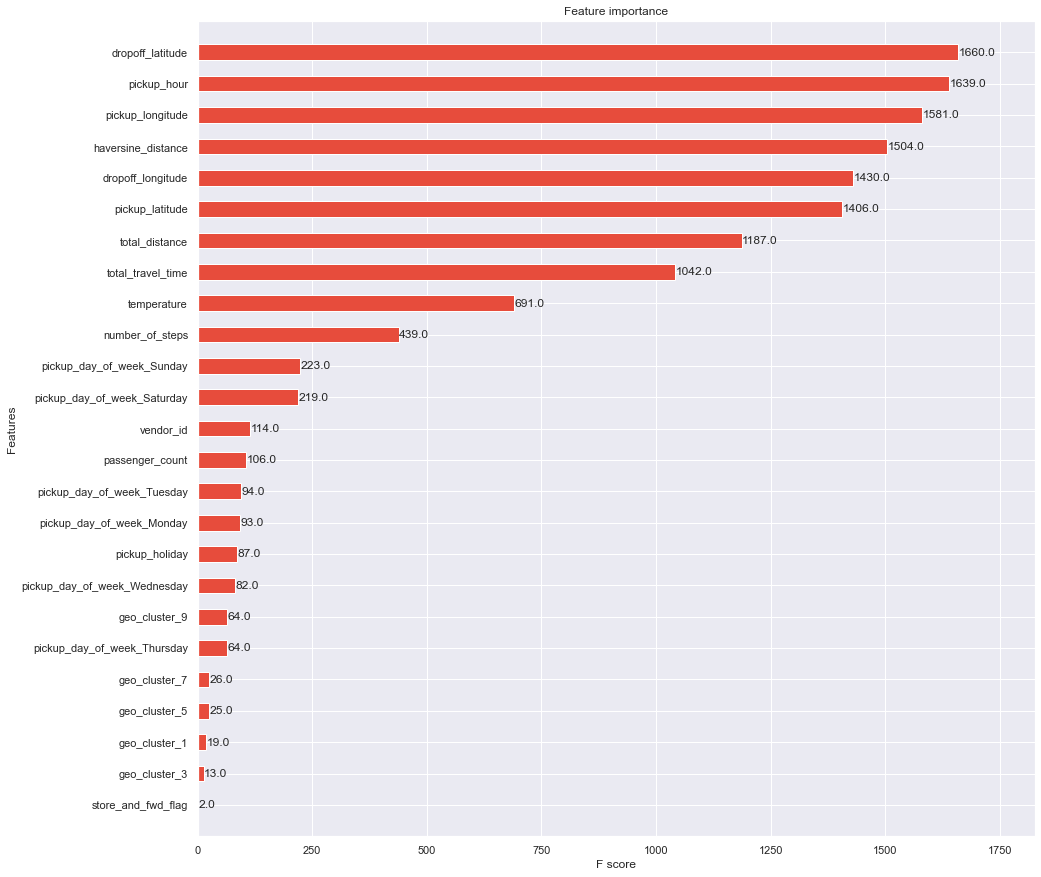

In [56]:
fig, ax = plt.subplots(figsize = (15,15))
xgb.plot_importance(model, ax = ax, height=0.5)

In [57]:
submission_xgb = pd.DataFrame({'id': test_id, 'trip_duration': y_test_predict})
submission_xgb.to_csv('submission_xgb.csv', index=False)